In [48]:
import pandas as pd
import numpy as np
import gpxpy
from matplotlib import pyplot as plt 
import folium
from haversine import haversine


In [49]:
filename = 'activity_10635475808.gpx' # example file

In [50]:
# OPEN GPX FILE WITH CONTEXT MANAGER

with open (filename) as gpx_file:
    gpx = gpxpy.parse(gpx_file)

# Summary of the route

In [3]:
# Quick look at the data
gpx.tracks[0].segments[0].points[0]

GPXTrackPoint(52.379920994862914, 17.095919558778405, elevation=106.4000015258789, time=datetime.datetime(2023, 3, 5, 14, 32, 33, tzinfo=SimpleTZ("Z")))

# EXTRACT DATA POINTS

In [4]:
route_info = []

for x in range(len(gpx.tracks[0].segments[0].points)):
    route_info.append({
                'latitude': gpx.tracks[0].segments[0].points[x].latitude,
                'longitude': gpx.tracks[0].segments[0].points[x].longitude,
                'elevation': gpx.tracks[0].segments[0].points[x].elevation,
                'time': gpx.tracks[0].segments[0].points[x].time
                })
               # 'elevation': point.elevation
    
   # print(gpx.tracks[0].segments[0].points[x].latitude)
route_df = pd.DataFrame(route_info)

# Calculate elevation difference and distance between points

In [31]:
route_df['elevation_diff'] = route_df['elevation'].diff()

In [32]:
# calculate distances between points
distances = [0]
for x in range(len(route_df)-1):
    distances.append(haversine((route_df['latitude'].iloc[x], route_df['longitude'].iloc[x]), (route_df['latitude'].iloc[x+1], route_df['longitude'].iloc[x+1])))

In [33]:
route_df['distances'] = distances # distance in km
route_df['distances [m]'] = route_df['distances']*1000 # calculate distance in m
route_df['distance_cumsum [m]'] = route_df['distances [m]'].cumsum() # calculate cummulative distance

# Calculate slope on the route

In [39]:
route_df['slope'] = (route_df['elevation_diff'] / route_df['distances [m]']) * 100
route_df['slope'].max()

# Filter slope values - there are many irrational values
route_df['slope_corrected']  = np.where(route_df['slope'].abs() > 30, np.NaN, route_df['slope'])
route_df['slope_corrected'] = route_df['slope_corrected'].interpolate().fillna(0)

In [44]:
elevation_gain = route_df['elevation_diff'].where(route_df['elevation_diff']>0).sum()
elevation_loss = route_df['elevation_diff'].where(route_df['elevation_diff']<0).sum()

# Data summary

In [17]:
total_dist = sum(route_df['distances']) 
num_of_points = gpx.get_track_points_no()

In [18]:
print(f'Route distance: {round(total_dist,2)} km')
print(f'Number of recorded track points: {num_of_points}')
print(f'Elevation minimum: {gpx.get_elevation_extremes().minimum}')
print(f'Elevation maximum: {gpx.get_elevation_extremes().maximum}')
print(f'Downhill: {gpx.get_uphill_downhill().downhill}')
print(f'Uphill: {gpx.get_uphill_downhill().uphill}')
print(f'Elevation gain: {elevation_gain}')
print(f'Elevation loss: {elevation_loss}')
# print(f'Max slope: {}')

Route distance: 2.73 km
Number of recorded track points: 508
Elevation minimum: 104.4000015258789
Elevation maximum: 115.0
Downhill: 33.77997589111327
Uphill: 42.37997436523436
Elevation gain: 61.99995422363281
Elevation loss: -53.39995574951172


# Plot data

In [ ]:
route_map = folium.Map(
    location=[route_df['latitude'].iloc[int(num_of_points/2)], route_df['longitude'].iloc[int(num_of_points/2)]],
    zoom_start=15,
    tiles='OpenStreetMap',
    width=1024,
    height=600
)


coordinates = [tuple(x) for x in route_df[['latitude', 'longitude']].to_numpy()]
folium.PolyLine(coordinates, weight=6).add_to(route_map)

display(route_map)

# Elevation - function of route

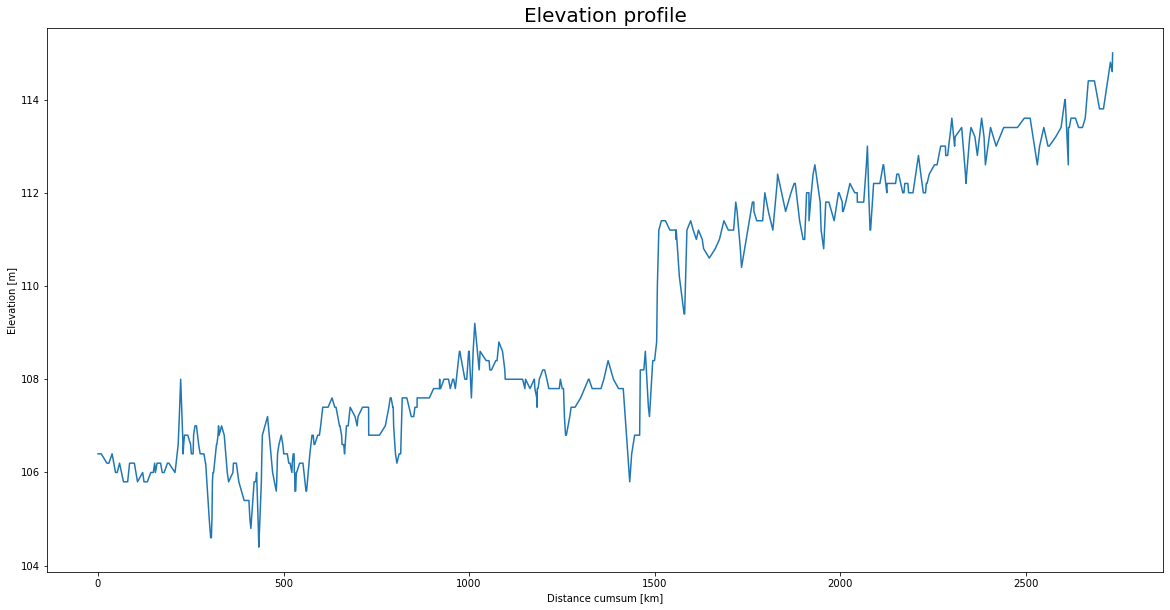

In [37]:
plt.figure(figsize=(20, 10))
plt.plot(route_df['distance_cumsum [m]'], route_df['elevation'])
plt.title('Elevation profile', size=20)
plt.xlabel('Distance cumsum [km]')
plt.ylabel('Elevation [m]')
plt.show()

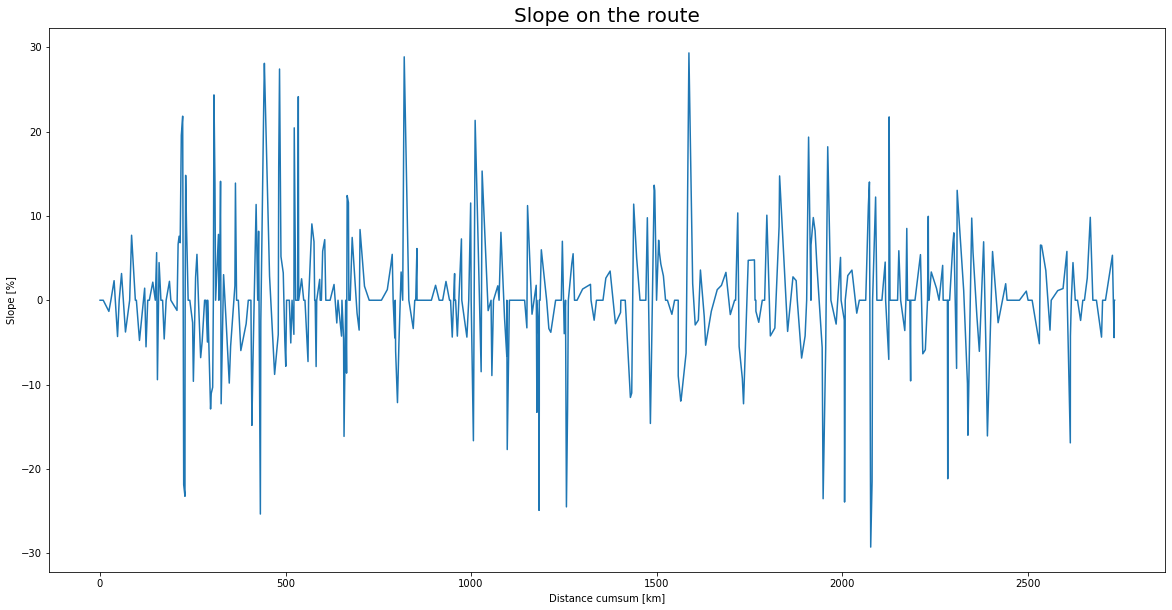

In [46]:
plt.figure(figsize=(20, 10))
plt.plot(route_df['distance_cumsum [m]'], route_df['slope_corrected'])
plt.title('Slope on the route', size=20)
plt.xlabel('Distance cumsum [km]')
plt.ylabel('Slope [%]')
plt.show()